# TrainBN

In [1]:
using AutomotiveDrivingModels
using DynamicBayesianNetworkBehaviors

  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:7
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:9
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21


## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [4]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [5]:
train_def = BehaviorTrainDefinition(
                                    BN_TrainParams(
                                        indicators=INDICATOR_SET2,
                                        preoptimize_target_bins=true,
                                        preoptimize_indicator_bins=true,
                                        optimize_structure=true,
                                        optimize_target_bins=false,
                                        optimize_parent_bins=false,
                                        ncandidate_bins=20,
                                    ),
                                    [
                                        BehaviorParameter(:max_parents, 3:7, 2),
                                        BehaviorParameter(:dirichlet_prior, [UniformPrior(), BDeuPrior(0.5), BDeuPrior(1.0), BDeuPrior(2.0), BDeuPrior(10.0)], 1),
                                    ])

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
BN Train Params
starting_structure
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
forced
	lat: AutomotiveDrivingModels.Features.AbstractFeature[]
	lon: AutomotiveDrivingModels.Features.AbstractFeature[]
targets
	lat: f_des_angle
	lon: f_accel
prior:           UniformPrior
verbosity:       0
ncandidate_bins: 20
max_parents:     6
nbins_lat:       7
nbins_lon:       7
preoptimize_target_bins:    true
preoptimize_indicator_bins: true
optimize_structure:         true
optimize_target_bins:       false
optimize_parent_bins:       false

hyperparams:
	max_parents:         [3, >4<, 5, 6, 7]
	dirichlet_prior:     [>UniformPrior<, BDeuPrior(0.50), BDeuPrior(1.00), BDeuPrior(2.00), BDeuPrior(10.00)]


In [6]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [19]:
BN = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(BN)

DynamicBayesianNetworkBehavior
	DBNModel: 
DBNModel
	f_des_angle <- [:velFt,:accFt]
	f_accel <- [:accFs,:has_lane_left]
	ind_lat:          1
	ind_lon:          2
	symbol_lat:       f_des_angle
	symbol_lon:       f_accel
	ordering:         [6,5,4,3,2,1]
	subset_extractor: AutomotiveDrivingModels.FeaturesNew.FeatureSubsetExtractor([0.0,1.060997896e-314,0.0,0.0],AutomotiveDrivingModels.FeaturesNew.AbstractFeature[AutomotiveDrivingModels.FeaturesNew.Feature_VelFt(),AutomotiveDrivingModels.FeaturesNew.Feature_AccFs(),AutomotiveDrivingModels.FeaturesNew.Feature_AccFt(),AutomotiveDrivingModels.FeaturesNew.Feature_Has_Lane_Left()])
	action_clamper:   AutomotiveDrivingModels.FeaturesNew.DataClamper([6.9432266573556e-310,6.9432266381495e-310],[-0.5586391289139377,-3.3573211206085176],[0.43804364359439696,3.3280399188834835])


## Likelihood

In [20]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    if trains_with_nona(BN)
        logl = calc_action_loglikelihood(BN, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(BN, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%10s  %10s  %10s  %10s\n", "min", "mean", "median", "max")
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

       min        mean      median         max
  -12.2394      2.9810      3.7160      9.1949
   -4.0236      3.8204      4.2096      5.0500


    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:

-12.239444953422133,9.194872352830188)
extrema test:  (-4.0236098042355515,5.049953921414842)


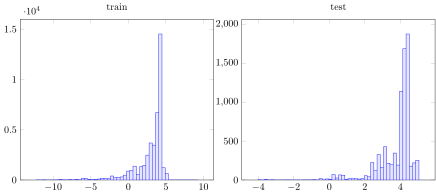

In [9]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

## Why is BN turning off-course?

In [10]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_dbn_cairo_utils.jl"))

    writemime(Base.IO, Base.Multimedia.MIME, Reactive.Signal) at /home/tim/.julia/v0.4/Interact/src/IJulia/setup.jl:99
is ambiguous with: 
    writemime(Base.IO, Base.Multimedia.MIME{:text/plain}, Any) at replutil.jl:4.
To fix, define 
    writemime(Base.IO, Base.Multimedia.MIME{:text/plain}, Reactive.Signal)
before the new definition.
  likely near /home/tim/.julia/v0.4/Reel/src/Reel.jl:14
  likely near /home/tim/.julia/v0.4/Reel/src/Reel.jl:14
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/MacroTools/src/utils.jl:108
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/tim/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/tim/.julia/v0.4/IJulia/src/IJu

Interact.Slider{Int64}(Signal{Int64}(760, nactions=0),"frame",760,1:1519)

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/MacroTools/src/utils.jl:108
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/tim/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/tim/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/tim/.julia/v0.4/Reel/src/Reel.jl, in expression starting on line 85
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/MacroTools/src/utils.jl:108
 in include at ./boot.jl

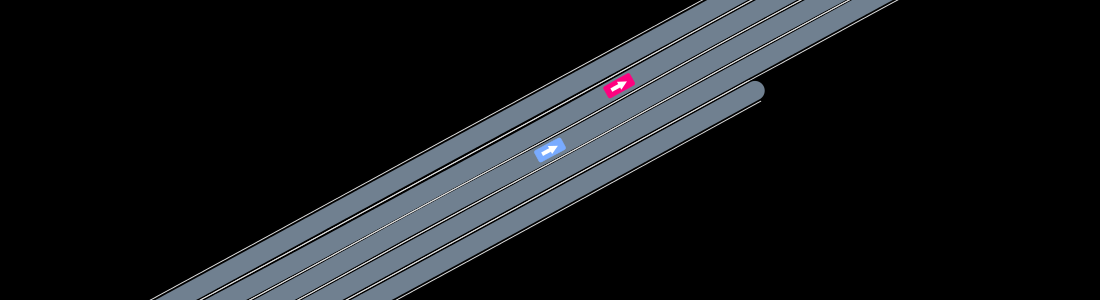

In [11]:
runlog = runlogs_original[1]
sn = streetnets[runlog.header.map_name]
plot_manipulable_runlog(runlog, sn)

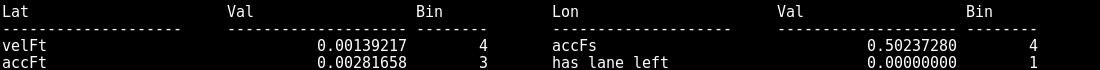

In [12]:
frame = 1311
plot_dbn_indicators(runlog, sn, BN, id2colset(runlog, RunLogs.ID_EGO, frame), frame)

In [13]:
plot_counts_over_conditioned_bin(runlog, sn, BN, id2colset(runlog, RunLogs.ID_EGO, frame), frame)

In [14]:
runlogseg = dset.runlog_segments[104]

RunLogSegment
	runlog_id:   16
	carid:       1
	frame_start: 2158
	frame_end:   2238


Interact.Slider{Int64}(Signal{Int64}(2178, nactions=0),"frame",2178,2118:2238)

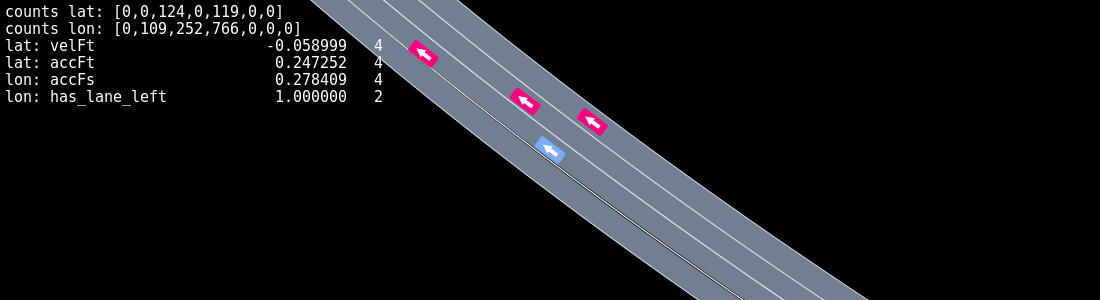

In [15]:
runlog = runlogs_original[runlogseg.runlog_id]
sn = streetnets[runlog.header.map_name]

seg_duration = runlogseg.frame_end - runlogseg.frame_start
where_to_start_copying_from_original_runlog = max(1, runlogseg.frame_start - DEFAULT_TRACE_HISTORY)
where_to_start_simulating_from_runlog_sim = runlogseg.frame_start - where_to_start_copying_from_original_runlog + 1
where_to_end_simulating_from_runlog_sim = where_to_start_simulating_from_runlog_sim + seg_duration

runlog_sim = deepcopy(runlog, where_to_start_copying_from_original_runlog, runlogseg.frame_end)
plot_manipulable_runlog(runlog, sn, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end, overlays=Overlay[BNCountsOverlay(BN)])
# roll(
#     reel_runlog(runlog, sn, runlogseg.carid, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end),
#     fps=40)

In [16]:
simulate!(runlog_sim, sn, BN, runlogseg.carid, 
          where_to_start_simulating_from_runlog_sim, where_to_end_simulating_from_runlog_sim);

Interact.Slider{Int64}(Signal{Int64}(61, nactions=0),"frame",61,1:121)

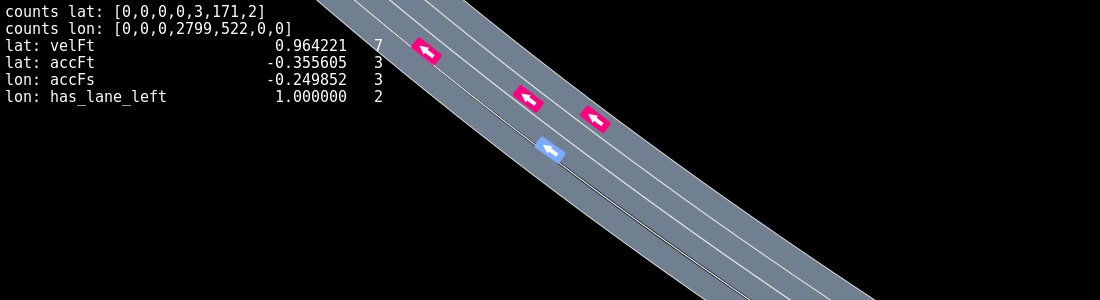

In [17]:
plot_manipulable_runlog(runlog_sim, sn, overlays=Overlay[BNCountsOverlay(BN)])
# roll(reel_runlog(runlog_sim, sn, runlogseg.carid, overlays=Overlay[BNCountsOverlay(BN)]), fps=40)

In [18]:
println("binedges lat: ", map(e->parse(Float64, @sprintf("%.3f",e)), BN.model.discretizers[BN.ind_lat].binedges))
println("binedges lon: ", map(e->parse(Float64, @sprintf("%.3f",e)), BN.model.discretizers[BN.ind_lon].binedges))
println("symbol lat: ", BN.symbol_lat)
println("symbol lon: ", BN.symbol_lon)

binedges lat: 